# Create a feature engineering pipeline

In Section 1, you tabularized a sales time series dataset to forecast sales for the next week.

In this assignment, your task is to line up those feature engineering steps within a pipeline to directly obtain the features from the input data and then forecast sales using Lasso.

The most straightforward method is probably to use the open-source library Feature-engine. But you are welcome to use other libraries, code your transformers manually, or, why not, code our own pipeline?

To prepare the dataset for this assignment, please follow the guidelines in the notebook `02-create-online-retail-II-datasets.ipynb` in the `01-Create-Datasets` folder.

In [63]:
# imports
import pandas as pd
import matplotlib.pyplot as plt
from feature_engine.creation import CyclicalFeatures
from feature_engine.datetime import DatetimeFeatures
from feature_engine.imputation import DropMissingData
from feature_engine.selection import DropFeatures
from feature_engine.timeseries.forecasting import (
    LagFeatures,
    WindowFeatures,
)

from sklearn.pipeline import Pipeline
from sklearn.linear_model import Lasso
from sklearn.metrics import mean_squared_error

In [4]:
# load weekly sales dataset

# Adjust the following function based on where 
# you stored the dataset
filename = "online_retail_dataset.csv"

data = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

data.columns = ['sales']

data.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


## Plot time series

<AxesSubplot:xlabel='week'>

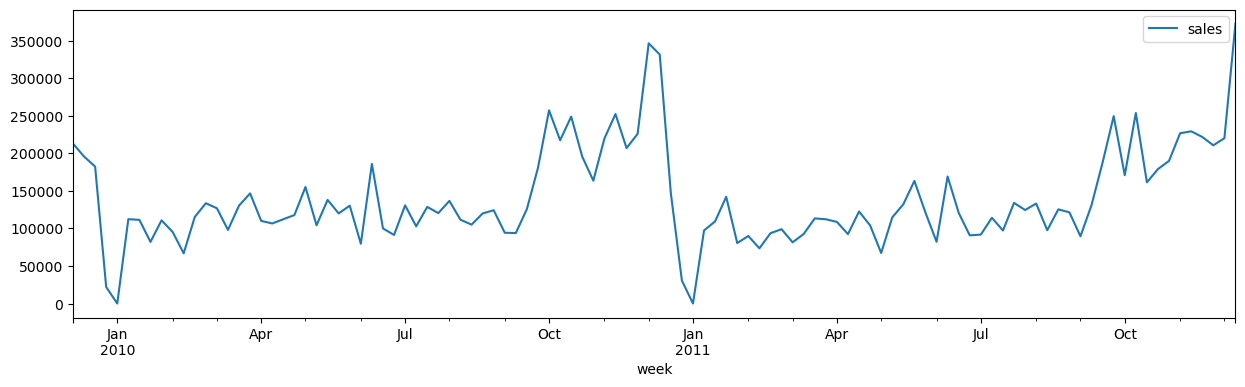

In [5]:
data.plot(figsize=[15, 4])

## Feature engineering

These are the feature engineering steps that you need to fit into a pipeline:

- Datetime features: Create the feature **month** from the timestamp.
- Cyclical features: transform the month with the sine and cosine functions.
- Lag features: Create the feature lag-1 by lagging 1 week of data.
- Window features: take the min, max and average sales values in the past 2 and 4 weeks of data.
- Drop missing data.

First set up suitable transformers / transformations and make sure they work.

In [6]:
# Create the feature month from the timestamp.
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
    ],
)

# Extract the datetime features
data = dtf.fit_transform(data)

# Show new variables
data.head()

,sales,month
week,,
2009-12-06,213000.35,12
2009-12-13,195810.04,12
2009-12-20,182396.74,12
2009-12-27,22007.77,12
2010-01-03,0.00,1


In [7]:
# Transform the month with the sine and cosine functions
cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month"],
    # Whether to drop the original features.
    drop_original=False,
)

data = cyclicf.fit_transform(data)

data[[v for v in data.columns if "month" in v]].head()

,month,month_sin,month_cos
week,,,
2009-12-06,12,-2.449294e-16,1.000000
2009-12-13,12,-2.449294e-16,1.000000
2009-12-20,12,-2.449294e-16,1.000000
2009-12-27,12,-2.449294e-16,1.000000
2010-01-03,1,5.000000e-01,0.866025


In [8]:
data.head()

,sales,month,month_sin,month_cos
week,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000
2009-12-13,195810.04,12,-2.449294e-16,1.000000
2009-12-20,182396.74,12,-2.449294e-16,1.000000
2009-12-27,22007.77,12,-2.449294e-16,1.000000
2010-01-03,0.00,1,5.000000e-01,0.866025


In [12]:
# Create the feature lag-1 by lagging 1 week of data.
lagf = LagFeatures(
    variables=["sales"],  # the input variables
    freq = ["7D"],  
    missing_values="ignore",
)

# Add the lag features.
data = lagf.fit_transform(data)

# Show new variables
data[[v for v in data.columns if "lag" in v]].head()

,sales_lag_7D
week,
2009-12-06,NaN
2009-12-13,213000.35
2009-12-20,195810.04
2009-12-27,182396.74
2010-01-03,22007.77


In [13]:
data.head()

,sales,month,month_sin,month_cos,sales_lag_7D
week,,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000,NaN
2009-12-13,195810.04,12,-2.449294e-16,1.000000,213000.35
2009-12-20,182396.74,12,-2.449294e-16,1.000000,195810.04
2009-12-27,22007.77,12,-2.449294e-16,1.000000,182396.74
2010-01-03,0.00,1,5.000000e-01,0.866025,22007.77


In [24]:
# Here we take the average, maximum, and minimum values
# of the previous 2 and 4 weeks
winf = WindowFeatures(
    variables=["sales"],  # the input variables
    window=[14,28],  # average of 2 and 4 weeks
    functions=['mean', 'max', 'min'],  # the summary statistics to compute
    missing_values="ignore",
)

# Add the window features.
data = winf.fit_transform(data)

# Show new variables
data[[v for v in data.columns if "window" in v]].head()

,sales_window_14_mean,sales_window_14_max,sales_window_14_min,sales_window_28_mean,sales_window_28_max,sales_window_28_min
week,,,,,,
2009-12-06,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-27,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
data

,sales,month,month_sin,month_cos,sales_lag_7D,sales_window_14_mean,sales_window_14_max,sales_window_14_min,sales_window_28_mean,sales_window_28_max,sales_window_28_min
week,,,,,,,,,,,
2009-12-06,213000.35,12,-2.449294e-16,1.000000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-13,195810.04,12,-2.449294e-16,1.000000,213000.35,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-20,182396.74,12,-2.449294e-16,1.000000,195810.04,NaN,NaN,NaN,NaN,NaN,NaN
2009-12-27,22007.77,12,-2.449294e-16,1.000000,182396.74,NaN,NaN,NaN,NaN,NaN,NaN
2010-01-03,0.00,1,5.000000e-01,0.866025,22007.77,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
2011-11-13,229378.01,11,-5.000000e-01,0.866025,226770.53,165562.815857,253713.54,89577.65,140765.306179,253713.54,67331.93
2011-11-20,221870.29,11,-5.000000e-01,0.866025,229378.01,172435.861571,253713.54,89577.65,146552.666179,253713.54,82246.14
2011-11-27,210741.76,11,-5.000000e-01,0.866025,221870.29,181308.608000,253713.54,89577.65,150379.159750,253713.54,82246.14


In [26]:
# Drop missing data.
data.isnull().sum()

sales                    0
month                    0
month_sin                0
month_cos                0
sales_lag_7D             1
sales_window_14_mean    14
sales_window_14_max     14
sales_window_14_min     14
sales_window_28_mean    28
sales_window_28_max     28
sales_window_28_min     28
dtype: int64

In [27]:
print(data.shape)

imputer = DropMissingData()

data = imputer.fit_transform(data)

print(data.shape)

(106, 11)
(78, 11)


In [28]:
# Drop original time series
drop_ts = DropFeatures(features_to_drop=["sales"])

data = drop_ts.fit_transform(data)

data.head()

,month,month_sin,month_cos,sales_lag_7D,sales_window_14_mean,sales_window_14_max,sales_window_14_min,sales_window_28_mean,sales_window_28_max,sales_window_28_min
week,,,,,,,,,,
2010-06-20,6,1.224647e-16,-1.000000,185933.06,123951.064429,185933.06,79636.37,117968.977857,213000.35,0.0
2010-06-27,6,1.224647e-16,-1.000000,100020.73,124092.545143,185933.06,79636.37,113933.991429,195810.04,0.0
2010-07-04,7,-5.000000e-01,-0.866025,91351.12,121296.302929,185933.06,79636.37,110203.315714,185933.06,0.0
2010-07-11,7,-5.000000e-01,-0.866025,130757.87,120158.207214,185933.06,79636.37,108359.070357,185933.06,0.0
2010-07-18,7,-5.000000e-01,-0.866025,102841.04,119641.597929,185933.06,79636.37,111245.972857,185933.06,0.0


## ML Workflow

- Load the data again.
- Split the data into a suitable train and test set.
- Align all feature engineering steps in a pipeline.
- Create the features.
- Train a model.
- Evaluate the model.

In [102]:
# load weekly sales dataset

# adjust the following function based on where 
# you stored the dataset
filename = "online_retail_dataset.csv"

data = pd.read_csv(
    filename,
    usecols=["week", "United Kingdom"],
    parse_dates=["week"],
    index_col=["week"],
)

data.columns = ['sales']

data.head()

,sales
week,
2009-12-06,213000.35
2009-12-13,195810.04
2009-12-20,182396.74
2009-12-27,22007.77
2010-01-03,0.00


In [103]:
data.tail()

,sales
week,
2011-11-13,229378.01
2011-11-20,221870.29
2011-11-27,210741.76
2011-12-04,220213.99
2011-12-11,372946.26


In [104]:
data.index.min(), df.index.max()

(Timestamp('2009-12-06 00:00:00'), Timestamp('2011-12-11 00:00:00'))

In [105]:
# Split the data.
train_start_date = pd.Timestamp('2009-12-06 00:00:00')
train_end_date = pd.Timestamp('2011-05-29 00:00:00')
test_start_date = pd.Timestamp('2011-06-05 00:00:00')
test_end_date = pd.Timestamp('2011-12-11 00:00:00')

# input data
X_train = data.loc[(data.index >= train_start_date) & (data.index <= train_end_date)]
X_test = data.loc[(data.index >= test_start_date) & (data.index <= test_end_date)]

# target

Y_train = data.loc[(y.index >= train_start_date) & (data.index <= train_end_date)]['sales']
Y_test = data.loc[(y.index >= test_start_date) & (data.index <= test_end_date)]['sales']


In [106]:
print("Training data shape: X={}, y={}".format(X_train.shape, Y_train.shape))
print("Testing data shape: X={}, y={}".format(X_test.shape, Y_test.shape))

Training data shape: X=(78, 1), y=(78,)
Testing data shape: X=(28, 1), y=(28,)


In [99]:
# The offset for the test set
#pd.Timestamp("2011-09-26") -  pd.tseries.offsets.Week(n=1)

In [107]:
# Target (in this dataset, is is the train set itself)
pipe = Pipeline(
    [
        ("datetime_features", dtf),
        ("lagf", lagf),
        ("winf", winf),
        ("Periodic", cyclicf),
        ("dropna", imputer),
        ("drop_ts", drop_ts),
    ]
)

In [108]:
# Data with input features.
X_train_t = pipe.fit_transform(X_train)

# Data with input features.
X_train_t.head()


,month,sales_lag_7D,sales_window_14_mean,sales_window_14_max,sales_window_14_min,sales_window_28_mean,sales_window_28_max,sales_window_28_min,month_sin,month_cos
week,,,,,,,,,,
2010-06-20,6,185933.06,123951.064429,185933.06,79636.37,117968.977857,213000.35,0.0,1.224647e-16,-1.000000
2010-06-27,6,100020.73,124092.545143,185933.06,79636.37,113933.991429,195810.04,0.0,1.224647e-16,-1.000000
2010-07-04,7,91351.12,121296.302929,185933.06,79636.37,110203.315714,185933.06,0.0,-5.000000e-01,-0.866025
2010-07-11,7,130757.87,120158.207214,185933.06,79636.37,108359.070357,185933.06,0.0,-5.000000e-01,-0.866025
2010-07-18,7,102841.04,119641.597929,185933.06,79636.37,111245.972857,185933.06,0.0,-5.000000e-01,-0.866025


In [109]:
print(Y_train.shape)

y_train_t = Y_train.loc[X_train_t.index]

print(y_train_t.shape)

(78,)
(50,)


## Machine Learning

In [110]:
linear_model = Lasso(alpha=100, random_state=0)

linear_model.fit(X_train_t, y_train_t)
# Make predictions

preds = linear_model.predict(X_train_t)

#preds

# Performance of linear model

print("train rmse: ", mean_squared_error(
    y_train_t, linear_model.predict(X_train_t), squared=False,))

#print("test rmse: ",  mean_squared_error(
     #Y_test, linear_model.predict(X_test), squared=False,))

train rmse:  32372.01303426962


Text(0.5, 1.0, 'Forecast: train set')

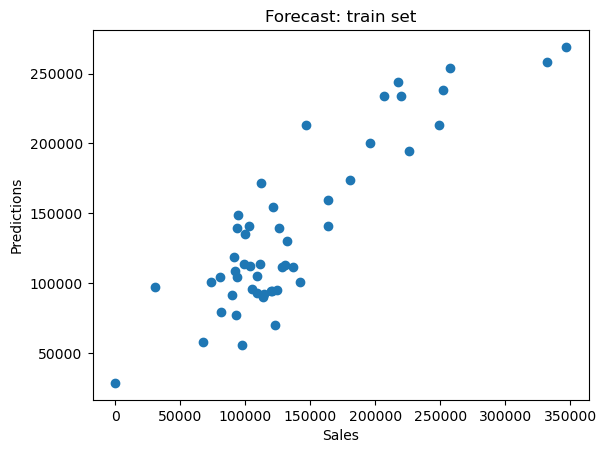

In [111]:
# Plot the predictions vs the truth.

plt.scatter(y_train_t, linear_model.predict(X_train_t))
plt.xlabel("Sales")
plt.ylabel("Predictions")
plt.title("Forecast: train set")

In [119]:
#X_test_t = pipe.transform(X_test)

#X_test_t.head()
dtf = DatetimeFeatures(
    # the datetime variable
    variables="index",
    
    # the features we want to create
    features_to_extract=[
        "month",
    ],
)

# Extract the datetime features
X_test = dtf.fit_transform(X_test)

X_test

,sales,month
week,,
2011-06-05,82246.140,6
2011-06-12,169194.050,6
2011-06-19,120797.680,6
2011-06-26,90786.390,6
2011-07-03,91812.150,7
2011-07-10,114199.460,7
2011-07-17,97244.710,7
2011-07-24,134081.780,7
2011-07-31,124542.861,7


In [120]:
cyclicf = CyclicalFeatures(
    # The features we want to transform.
    variables=["month"],
    # Whether to drop the original features.
    drop_original=False,
)

X_test = cyclicf.fit_transform(X_test)


# Show new variables
X_test

,sales,month,month_sin,month_cos
week,,,,
2011-06-05,82246.140,6,1.224647e-16,-1.000000e+00
2011-06-12,169194.050,6,1.224647e-16,-1.000000e+00
2011-06-19,120797.680,6,1.224647e-16,-1.000000e+00
2011-06-26,90786.390,6,1.224647e-16,-1.000000e+00
2011-07-03,91812.150,7,-5.000000e-01,-8.660254e-01
2011-07-10,114199.460,7,-5.000000e-01,-8.660254e-01
2011-07-17,97244.710,7,-5.000000e-01,-8.660254e-01
2011-07-24,134081.780,7,-5.000000e-01,-8.660254e-01
2011-07-31,124542.861,7,-5.000000e-01,-8.660254e-01


In [121]:
lagf = LagFeatures(
    variables=["sales"],  # the input variables
    freq = ["7D"],  
    missing_values="ignore",
)

# Add the lag features.
X_test = lagf.fit_transform(X_test)
X_test

,sales,month,month_sin,month_cos,sales_lag_7D
week,,,,,
2011-06-05,82246.140,6,1.224647e-16,-1.000000e+00,NaN
2011-06-12,169194.050,6,1.224647e-16,-1.000000e+00,82246.140
2011-06-19,120797.680,6,1.224647e-16,-1.000000e+00,169194.050
2011-06-26,90786.390,6,1.224647e-16,-1.000000e+00,120797.680
2011-07-03,91812.150,7,-5.000000e-01,-8.660254e-01,90786.390
2011-07-10,114199.460,7,-5.000000e-01,-8.660254e-01,91812.150
2011-07-17,97244.710,7,-5.000000e-01,-8.660254e-01,114199.460
2011-07-24,134081.780,7,-5.000000e-01,-8.660254e-01,97244.710
2011-07-31,124542.861,7,-5.000000e-01,-8.660254e-01,134081.780


In [122]:
winf = WindowFeatures(
    variables=["sales"],  # the input variables
    window=[14,28],  # average of 2 and 4 weeks
    functions=['mean', 'max', 'min'],  # the summary statistics to compute
    missing_values="ignore",
)

# Add the window features.
X_test = winf.fit_transform(X_test)
X_test

,sales,month,month_sin,month_cos,sales_lag_7D,sales_window_14_mean,sales_window_14_max,sales_window_14_min,sales_window_28_mean,sales_window_28_max,sales_window_28_min
week,,,,,,,,,,,
2011-06-05,82246.140,6,1.224647e-16,-1.000000e+00,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-12,169194.050,6,1.224647e-16,-1.000000e+00,82246.140,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-19,120797.680,6,1.224647e-16,-1.000000e+00,169194.050,NaN,NaN,NaN,NaN,NaN,NaN
2011-06-26,90786.390,6,1.224647e-16,-1.000000e+00,120797.680,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-03,91812.150,7,-5.000000e-01,-8.660254e-01,90786.390,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-10,114199.460,7,-5.000000e-01,-8.660254e-01,91812.150,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-17,97244.710,7,-5.000000e-01,-8.660254e-01,114199.460,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-24,134081.780,7,-5.000000e-01,-8.660254e-01,97244.710,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-31,124542.861,7,-5.000000e-01,-8.660254e-01,134081.780,NaN,NaN,NaN,NaN,NaN,NaN


In [123]:
print(X_test.shape)

imputer = DropMissingData()

X_test = imputer.fit_transform(X_test)

print(X_test.shape)

(28, 11)
(0, 11)
